In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import utils_attributes_analysis
import utils

## Table of contents:
* [Dataset setup and description](#dataset)
* [Discretization of chunk numerical columns](#discretization)
* [Chunk attributes](#chunk)
    * [Distribution of chunk categorical attributes](#chunk_categorical_distribution)
    * [Distribution of chunk continuous attributes](#chunk_continuous_distribution)
    * [Distribution of chunk continuous attributes per developerdecision](#chunk_continuous_decision)
    * [Correlation between chunk continuous attributes and developerdecision](#correlation_chunk)
    * [Probability plots for chunk continuous attributes](#chunk_probability)
    * [Lift analysis for Chunk level attributes](#chunk_lift)
* [File attributes](#file)
    * [Distribution of file categorical attributes](#file_categorical_distribution)
    * [Lift analysis for File level attributes](#file_lift)
* [Merge attributes](#merge)
    * [Distribution of merge categorical attributes](#merge_categorical_distribution)
    * [Lift analysis for Merge level attributes](#merge_lift)

### Dataset setup and description <a class="anchor" id="dataset"></a>

In [2]:
df = pd.read_csv("../../data/selected_dataset.csv")
df = df[df['developerdecision']!='UnknownConcatenation']
df.head()

,chunk_id,developerdecision,line_start,line_end,line_separator,kind_conflict,url,project,project_user,project_name,path,file_name,sha,leftsha,rightsha,basesha,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkRelSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_left_rel_size,chunk_right_abs_size,chunk_right_rel_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection,self_conflict_perc
0,777206,ConcatenationV2V1,1108,1115,1110,"Attribute, Comment, Method invocation",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/Revie...,Reviewer.java,2d88e89330552363f1d2af979ac3ebf232a91fb3,9d7836b5669d0e46f064fc9e6f38cf083af0596d,1f156abfcadb3d3913098ee78c1bd0d94fb71e9b,64ee8602e09ea183670543eef0641cbbbaf73aa9,38.0,58.0,6088.0,19261.0,65.0,28.0,9.0,2.0,2.0,0.0,0.0,6.0,9.0,5.0,18.0,2.0,12.0,1.0,1.0,533.0,7.0,0.001966,1.0,3561.0,6.0,0.857143,1.0,0.142857,73.111331,74.987998,13.0,1.0,14.0,1.0,1.0,85.0,1.0,313.0,2.0,1.0,0.000000
1,777207,Version 1,0,199,130,"Comment, Method declaration",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/Revie...,Reviewer.java,2d5c6e5d12d784bd7538eb5aab421691ce4c688d,2cc6902f6ee2d91c8629a6e2c9a52e4e097bf458,b514b5f6701fda49873f080da5be47a16a960394,af5bfb3e0e56ecd8413c853d266babe49a95e16e,1312.0,1025.0,801.0,7814.0,7.0,9.0,0.0,1.0,1.0,0.0,0.0,1.0,4.0,4.0,6.0,0.0,8.0,0.0,6.0,532.0,43.0,0.012102,4.0,3553.0,0.0,0.000000,43.0,1.000000,41.629329,48.286817,8.0,3.0,11.0,2.0,1.0,9.0,25.0,25.0,108.0,1.0,NaN
2,777216,Combination,35,81,36,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/Revie...,Reviewer.java,f32b758df664833130d5d75006a09df0fae43d71,a4aadbce8fcf23feae6eae07232615200796f017,51e8088a8bb66a2724ca26c8aa84b8f4e7db1a4c,1faa5059f12dc3df89ac25550565b3cfda91a6a2,1686.0,785.0,7.0,26.0,0.0,16.0,4.0,6.0,1.0,0.0,0.0,4.0,3.0,7.0,1.0,6.0,8.0,3.0,1.0,511.0,5.0,0.001478,3.0,3383.0,4.0,0.800000,1.0,0.200000,7.969722,8.096076,2.0,4.0,6.0,1.0,1.0,3.0,32.0,5.0,94.0,1.0,0.000000
3,777218,Combination,24,69,25,"Comment, Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/anki/Revie...,Reviewer.java,f32b758df664833130d5d75006a09df0fae43d71,a4aadbce8fcf23feae6eae07232615200796f017,51e8088a8bb66a2724ca26c8aa84b8f4e7db1a4c,1faa5059f12dc3df89ac25550565b3cfda91a6a2,1686.0,785.0,7.0,26.0,0.0,16.0,4.0,6.0,1.0,0.0,0.0,4.0,3.0,7.0,1.0,6.0,8.0,1.0,1.0,511.0,4.0,0.001182,3.0,3383.0,2.0,0.500000,2.0,0.500000,7.969722,8.096076,2.0,4.0,6.0,1.0,1.0,3.0,32.0,5.0,94.0,1.0,0.333333
4,777221,Version 1,20,23,21,"Method invocation, Variable",https://github.com/Ramblurr/Anki-Android,Ramblurr/Anki-Android,Ramblurr,Anki-Android,Ramblurr/Anki-Android/src/com/ichi2/libanki/Me...,Media.java,59973c74b19c37712c469bdafbdb10cc665d7b93,d55c2d96484a99666182be460adde72090045317,17ffea93b3c39863f959d92f78c3df21818b74f8,7921c523e33cae37a7331396892feaf0830c4302,1682.0,2118.0,6.0,42.0,2.0,11.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,99.0,1.0,0.001311,4.0,763.0,0.0,0.000000,1.0,1.000000,18.725880,20.897963,1.0,3.0,4.0,0.0,0.0,2.0,29.0,5.0,276.0,1.0,NaN


In [3]:
total_chunks = len(df)
total_projects = len(pd.unique(df['project']))
total_merges = len(pd.unique(df['sha']))
print(f"The dataset has {total_merges} merges with {total_chunks} chunks from {total_projects} projects.")

The dataset has 7954 merges with 86214 chunks from 78 projects.


In [4]:
df.describe()

,chunk_id,line_start,line_end,line_separator,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkRelSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_left_rel_size,chunk_right_abs_size,chunk_right_rel_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection,self_conflict_perc
count,8.621400e+04,86214.000000,86214.000000,86214.000000,8.581800e+04,8.581800e+04,8.581800e+04,8.581800e+04,82273.000000,85818.000000,85818.000000,85818.00000,85818.000000,85818.000000,85818.000000,85818.000000,85818.000000,85818.000000,85818.000000,85818.000000,85818.000000,69560.000000,69560.000000,69560.000000,69560.000000,69560.000000,69560.000000,69560.000000,69560.000000,69560.000000,69560.000000,69560.000000,76064.000000,76064.000000,76064.000000,76064.000000,76064.000000,76064.000000,76064.000000,76064.000000,76064.000000,76064.000000,76064.000000,76064.000000,58351.000000
mean,1.164173e+06,4558.363885,4588.711137,4571.126499,5.040215e+03,4.000647e+04,5.249493e+04,9.934772e+04,8.345557,343.938113,173.805950,10.18608,22.238714,18.889825,17.106423,78.781118,263.507493,91.141019,156.405568,13.749447,423.338927,2.336156,3.427559,1547.779298,24.924540,0.041718,2.375791,15052.921320,10.025086,0.492563,14.899454,0.507293,55.760442,58.192593,32.422039,3.845564,36.267604,2.181426,0.836454,616.808569,152.020548,1534.091449,467.314564,0.982252,0.507145
std,2.251264e+05,15405.721219,15402.873034,15404.445904,5.201233e+04,2.812354e+05,2.389250e+05,2.498476e+05,25.775583,789.892532,501.532188,24.38461,46.138906,45.258760,34.686967,197.889900,579.512340,191.464779,343.142367,29.214790,1188.687982,9.443570,21.152963,3120.719983,194.217156,0.115041,1.140630,33800.501852,89.201456,0.254195,121.304763,0.254200,200.541940,203.515085,59.323468,7.073894,59.557510,5.318278,0.445282,1100.709275,555.847365,1781.645402,816.923020,0.136732,0.444131
min,7.772060e+05,0.000000,2.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.326053,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.829202e+05,58.000000,75.000000,67.000000,0.000000e+00,0.000000e+00,1.815000e+03,3.363000e+03,0.000000,11.000000,1.000000,0.00000,1.000000,0.000000,1.000000,3.000000,15.000000,2.000000,3.000000,0.000000,2.000000,1.000000,1.000000,25.000000,2.000000,0.001288,1.000000,260.000000,1.000000,0.454545,1.000000,0.500000,0.870799,1.105312,2.000000,1.000000,4.000000,1.000000,1.000000,46.000000,1.000000,309.000000,17.000000,1.000000,0.000000
50%,1.138882e+06,212.000000,244.000000,226.000000,4.600000e+01,3.910000e+02,9.010000e+03,1.866150e+04,0.000000,51.000000,8.000000,2.00000,5.000000,3.000000,3.000000,13.000000,35.000000,12.000000,22.000000,1.000000,16.000000,1.000000,1.000000,103.000000,5.000000,0.007905,2.000000,760.000000,2.000000,0.500000,2.000000,0.500000,9.829526,11.114850,5.000000,1.000000,9.000000,1.000000,1.000000,118.000000,2.000000,1263.000000,71.000000,1.000000,0.500000
75%,1.352117e+06,822.000000,876.000000,841.000000,9.290000e+02,2.653000e+03,6.474200e+04,8.743000e+04,8.000000,234.000000,65.000000,6.00000,16.000000,13.000000,11.000000,65.000000,183.000000,74.000000,126.000000,11.000000,113.000000,2.000000,2.000000,572.000000,14.000000,0.031362,3.000000,3289.000000,6.000000,0.500000,6.000000,0.545455,20.910833,21.574421,28.000000,4.000000,36.000000,1.000000,1.000000,649.000000,44.000000,2166.000000,698.000000,1.000000,1.000000


In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = list(df.select_dtypes(include=numerics))
not_attributes_columns = ['chunk_id', 'line_start', 'line_end', 'line_separator']
float_columns = ['chunkRelSize','self_conflict_perc','chunk_left_rel_size', 'chunk_right_rel_size']
numeric_columns = [elem for elem in numeric_columns if elem not in not_attributes_columns]
numeric_columns = [elem for elem in numeric_columns if elem not in float_columns]
print(numeric_columns)

['left_lines_added', 'left_lines_removed', 'right_lines_added', 'right_lines_removed', 'conclusion_delay', 'keyword_fix', 'keyword_bug', 'keyword_feature', 'keyword_improve', 'keyword_document', 'keyword_refactor', 'keyword_update', 'keyword_add', 'keyword_remove', 'keyword_use', 'keyword_delete', 'keyword_change', 'leftCC', 'rightCC', 'fileCC', 'chunkAbsSize', 'chunkPosition', 'fileSize', 'chunk_left_abs_size', 'chunk_right_abs_size', 'Branching time', 'Merge isolation time', 'Devs 1', 'Devs 2', 'Different devs', 'Same devs', 'Devs intersection', 'Commits 1', 'Commits 2', 'Changed files 1', 'Changed files 2', 'Changed files intersection']


### Discretization of chunk numerical columns <a class="anchor" id="discretization"></a>

In [6]:
discretized, labels = utils.get_discretized_df(df, numeric_columns)
discretized

,chunk_id,developerdecision,left_lines_added,left_lines_removed,right_lines_added,right_lines_removed,conclusion_delay,keyword_fix,keyword_bug,keyword_feature,keyword_improve,keyword_document,keyword_refactor,keyword_update,keyword_add,keyword_remove,keyword_use,keyword_delete,keyword_change,leftCC,rightCC,fileCC,chunkAbsSize,chunkPosition,fileSize,chunk_left_abs_size,chunk_right_abs_size,Branching time,Merge isolation time,Devs 1,Devs 2,Different devs,Same devs,Devs intersection,Commits 1,Commits 2,Changed files 1,Changed files 2,Changed files intersection
0,777206,ConcatenationV2V1,Tens,Tens,Thousands,Tens of thousands,Tens,Tens,Few (<10),Few (<10),Few (<10),Zero,Zero,Few (<10),Few (<10),Few (<10),Tens,Few (<10),Tens,Few (<10),Few (<10),Hundreds,Few (<10),Few (<10),Thousands,Few (<10),Few (<10),Tens,Tens,Tens,Few (<10),Tens,Few (<10),Few (<10),Tens,Few (<10),Hundreds,Few (<10),Few (<10)
1,777207,Version 1,Thousands,Thousands,Hundreds,Thousands,Few (<10),Few (<10),Zero,Few (<10),Few (<10),Zero,Zero,Few (<10),Few (<10),Few (<10),Few (<10),Zero,Few (<10),Zero,Few (<10),Hundreds,Tens,Few (<10),Thousands,Zero,Tens,Tens,Tens,Few (<10),Few (<10),Tens,Few (<10),Few (<10),Few (<10),Tens,Tens,Hundreds,Few (<10)
2,777216,Combination,Thousands,Hundreds,Few (<10),Tens,Zero,Tens,Few (<10),Few (<10),Few (<10),Zero,Zero,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Hundreds,Few (<10),Few (<10),Thousands,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Tens,Few (<10),Tens,Few (<10)
3,777218,Combination,Thousands,Hundreds,Few (<10),Tens,Zero,Tens,Few (<10),Few (<10),Few (<10),Zero,Zero,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Hundreds,Few (<10),Few (<10),Thousands,Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Few (<10),Tens,Few (<10),Tens,Few (<10)
4,777221,Version 1,Thousands,Thousands,Few (<10),Tens,Few (<10),Tens,Few (<10),Zero,Zero,Zero,Zero,Few (<10),Few (<10),Few (<10),Few (<10),Zero,Few (<10),Zero,Few (<10),Tens,Few (<10),Few (<10),Hundreds,Zero,Few (<10),Tens,Tens,Few (<10),Few (<10),Few (<10),Zero,Zero,Few (<10),Tens,Few (<10),Hundreds,Few (<10)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86210,1658387,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Few (<10),Tens,Tens,Few (<10),Tens,Hundreds,Tens,Hundreds,Few (<10),Hundreds,Few (<10),Few (<10),Tens,Tens,Few (<10),Hundreds,Tens,Tens,Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Hundreds,Few (<10),Thousands,Thousands,Few (<10)
86211,1658389,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Few (<10),Tens,Tens,Few (<10),Tens,Hundreds,Tens,Hundreds,Few (<10),Hundreds,Few (<10),Few (<10),Hundreds,Few (<10),Few (<10),Hundreds,Few (<10),Few (<10),Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Hundreds,Few (<10),Thousands,Thousands,Few (<10)
86212,1658390,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Few (<10),Tens,Tens,Few (<10),Tens,Hundreds,Tens,Hundreds,Few (<10),Hundreds,Few (<10),Few (<10),Hundreds,Tens,Few (<10),Hundreds,Few (<10),Few (<10),Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Hundreds,Few (<10),Thousands,Thousands,Few (<10)
86213,1658391,Version 1,Zero,Zero,Thousands,Tens of thousands,Zero,Hundreds,Hundreds,Few (<10),Tens,Tens,Few (<10),Tens,Hundreds,Tens,Hundreds,Few (<10),Hundreds,Few (<10),Few (<10),Hundreds,Tens,Few (<10),Hundreds,Few (<10),Few (<10),Tens,Tens,Tens,Few (<10),Tens,Zero,Zero,Hundreds,Few (<10),Thousands,Thousands,Few (<10)


In [7]:
chunk_columns_categorical = ['leftCC', 'rightCC', 'chunkAbsSize', 'chunk_left_abs_size', 'chunk_right_abs_size' ]
chunk_columns_float = ['chunkRelSize', 'self_conflict_perc', 'chunk_left_rel_size', 'chunk_right_rel_size', 'chunkPosition' ]
# TODO: REMOVE THE LINE BELOW AFTER FIXING THIS ATTRIBUTE
# chunk_columns_float.remove('chunkRelSize')

file_columns_categorical = ['fileCC', 'fileSize']
# file_columns_float = []

merge_columns_categorical = ['left_lines_added', 'left_lines_removed', 'right_lines_added', 'right_lines_removed', 'conclusion_delay']
merge_columns_categorical.extend(['keyword_fix', 'keyword_bug', 'keyword_feature', 'keyword_improve', 'keyword_document'])
merge_columns_categorical.extend(['keyword_refactor', 'keyword_update','keyword_add', 'keyword_remove', 'keyword_use'])
merge_columns_categorical.extend(['keyword_delete', 'keyword_change', 'Branching time', 'Merge isolation time', 'Devs 1', 'Devs 2'])
merge_columns_categorical.extend(['Different devs', 'Same devs', 'Devs intersection', 'Commits 1', 'Commits 2'])
merge_columns_categorical.extend(['Changed files 1','Changed files 2', 'Changed files intersection'])
# merge_columns_float = []

 

## Chunk attributes  <a class="anchor" id="chunk"></a>

### Distribution of chunk categorical attributes <a class="anchor" id="chunk_categorical_distribution"></a>

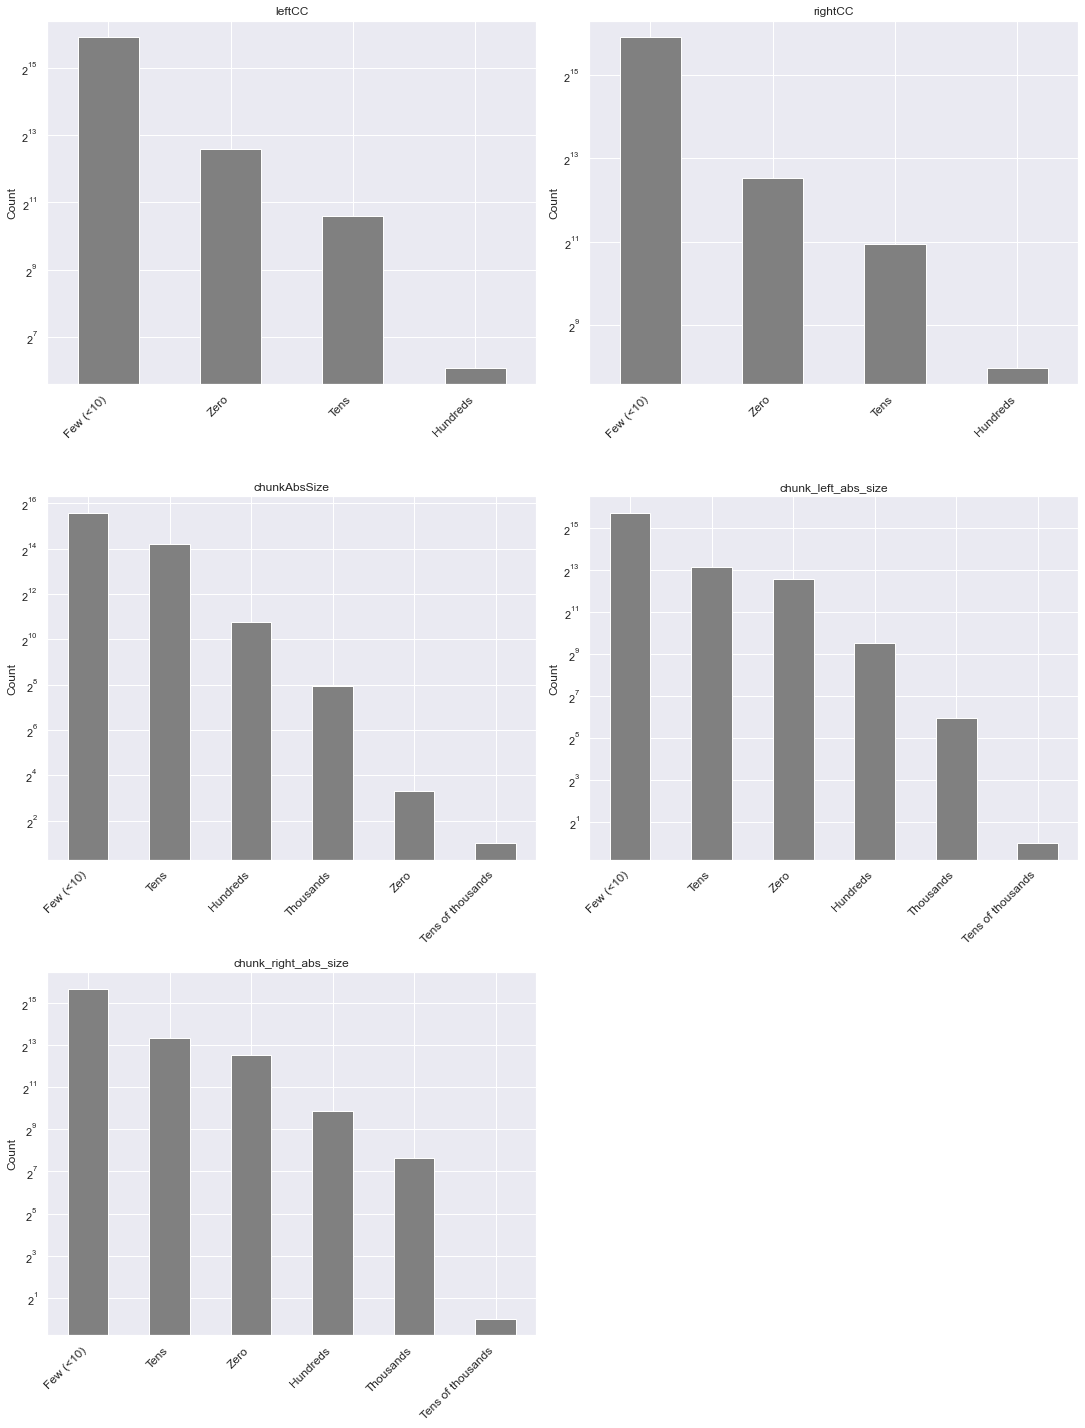

In [8]:
utils_attributes_analysis.count_plot_categorical(chunk_columns_categorical, discretized, 2, True, 2)

### Distribution of chunk continuous attributes <a class="anchor" id="chunk_continuous_distribution"></a>

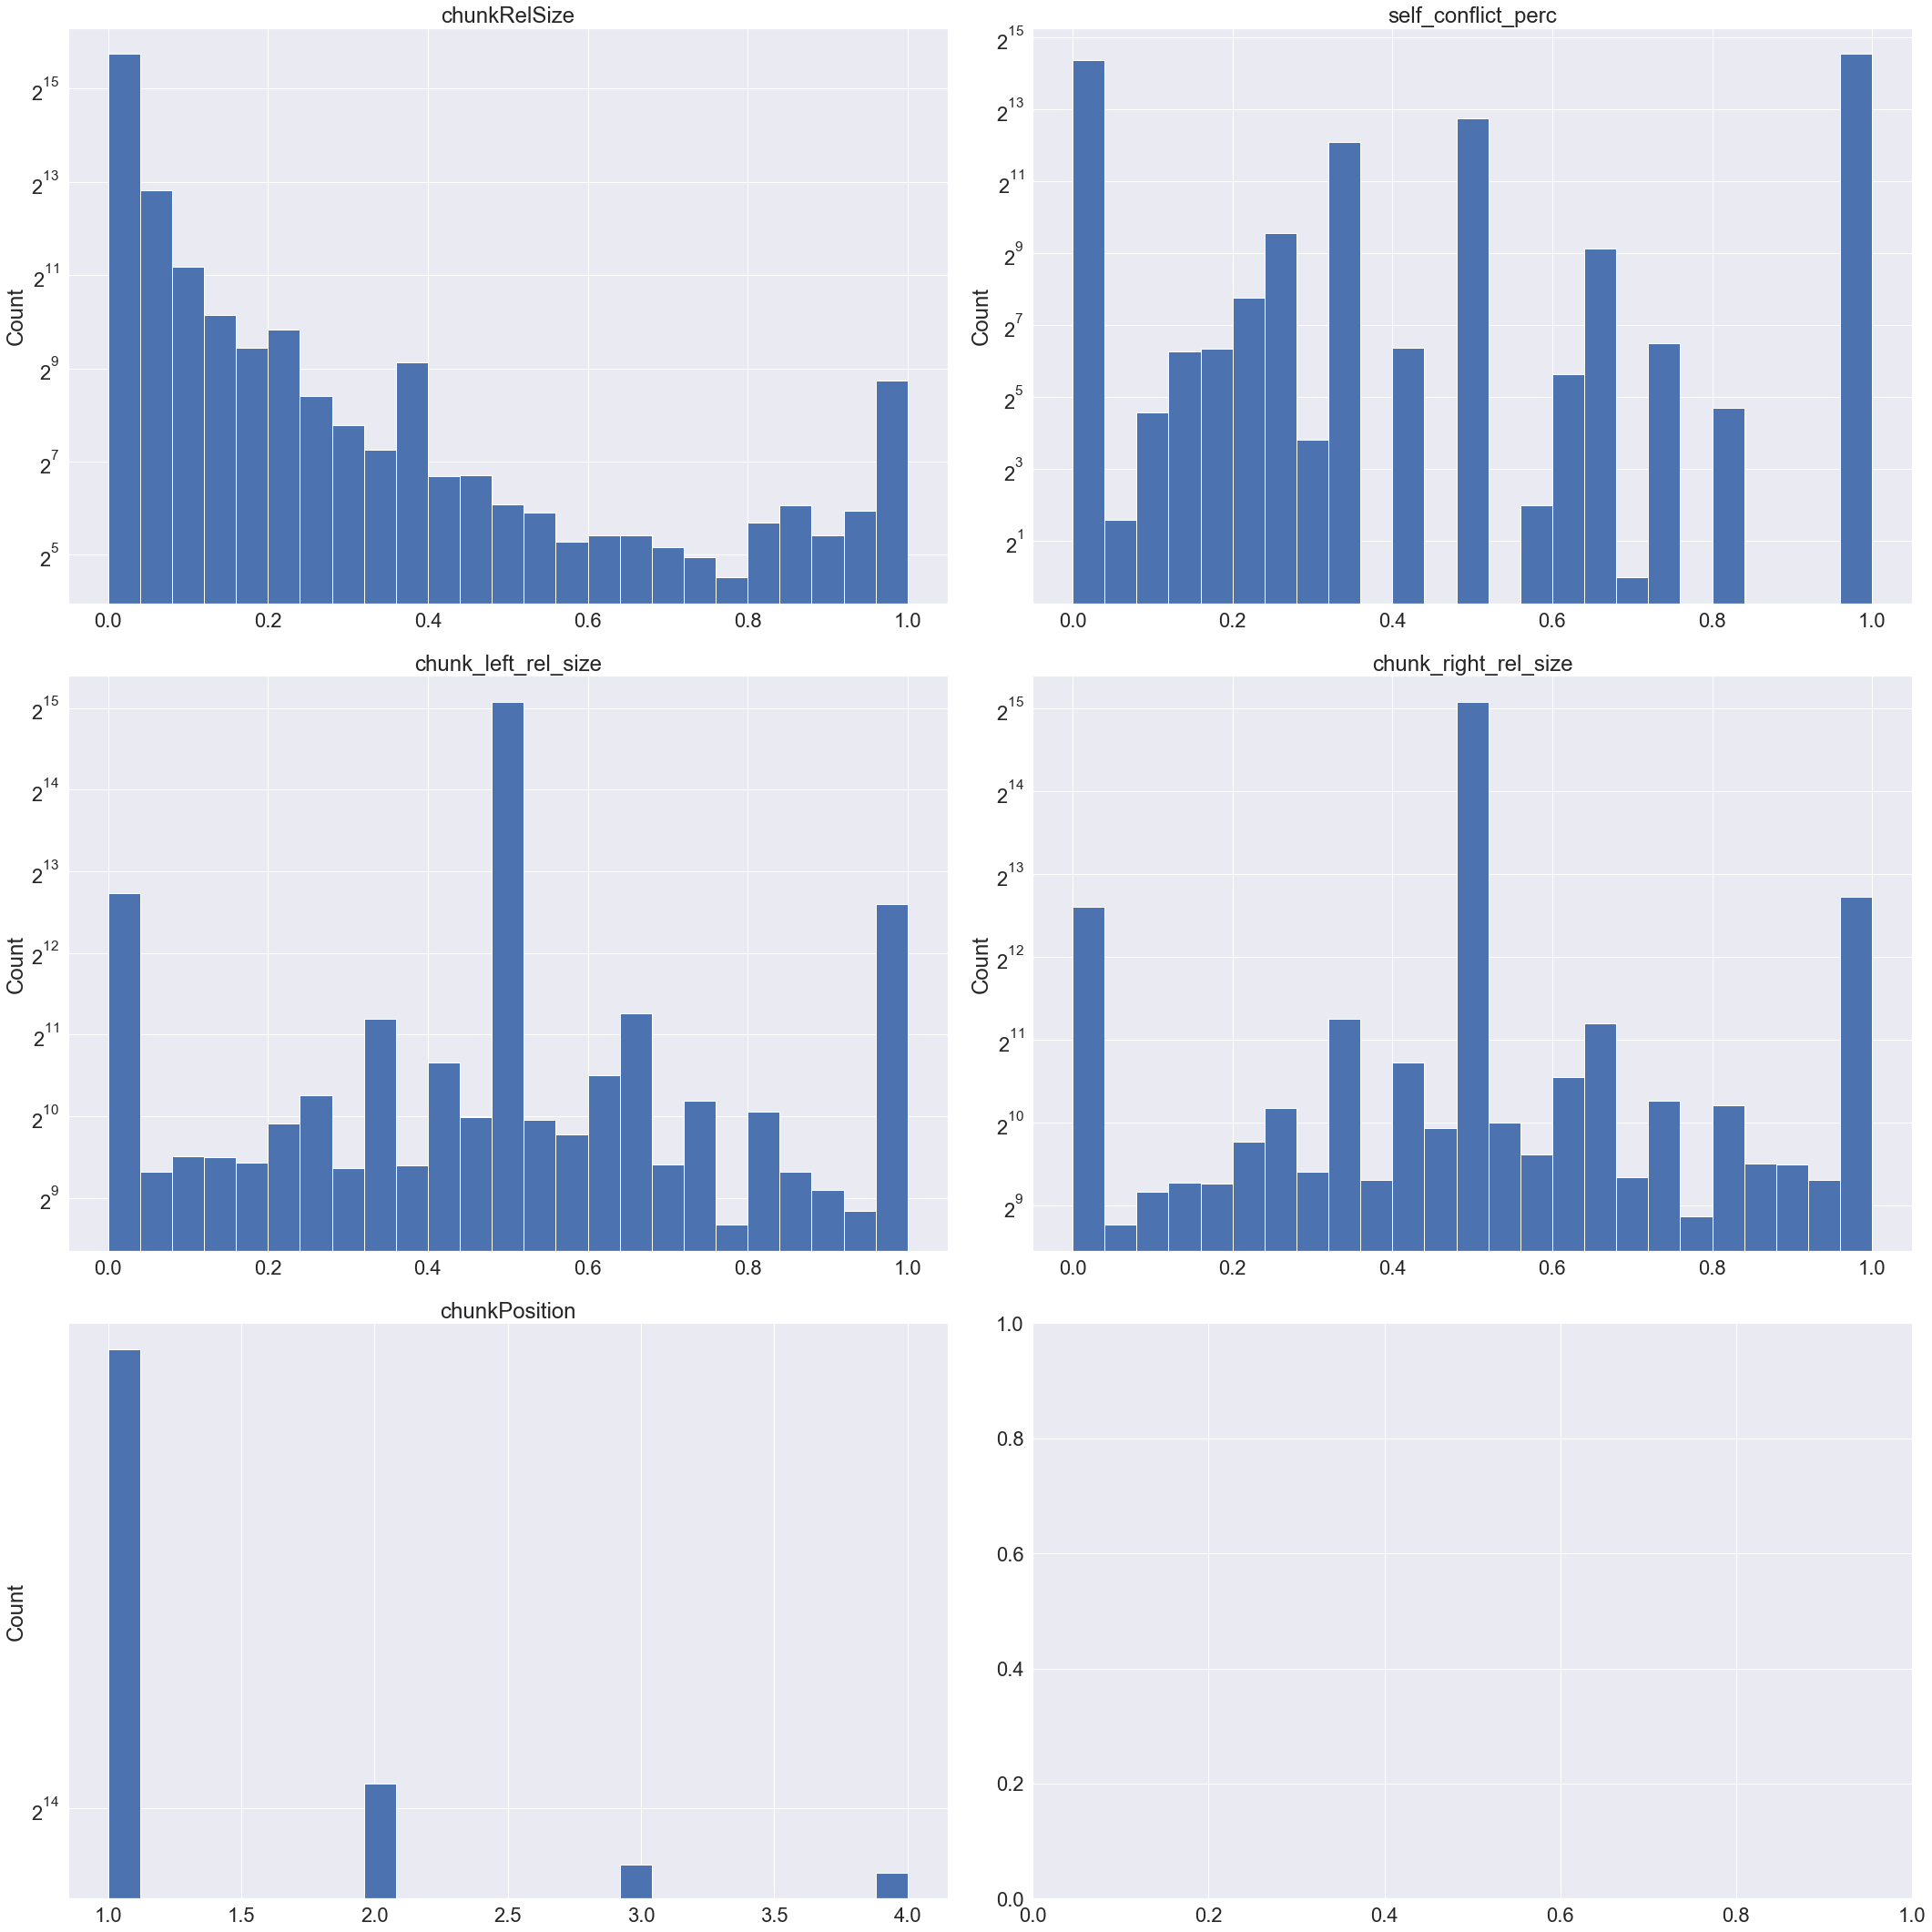

In [9]:
utils_attributes_analysis.hist_plot(chunk_columns_float, df, 2, True, 2)

### Distribution of chunk continuous attributes per developerdecision <a class="anchor" id="chunk_continuous_decision"></a>

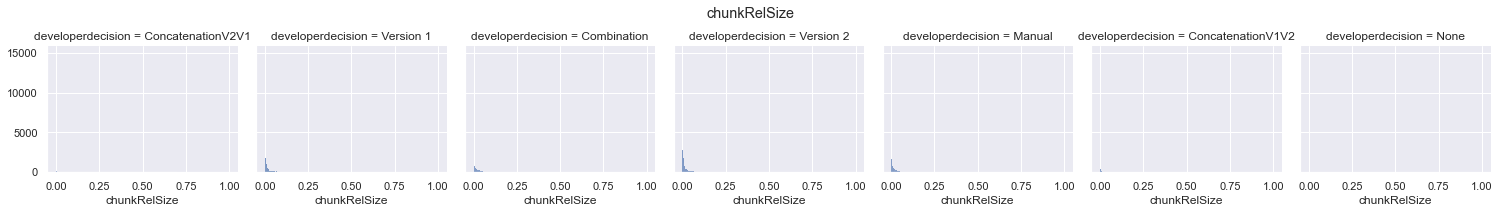

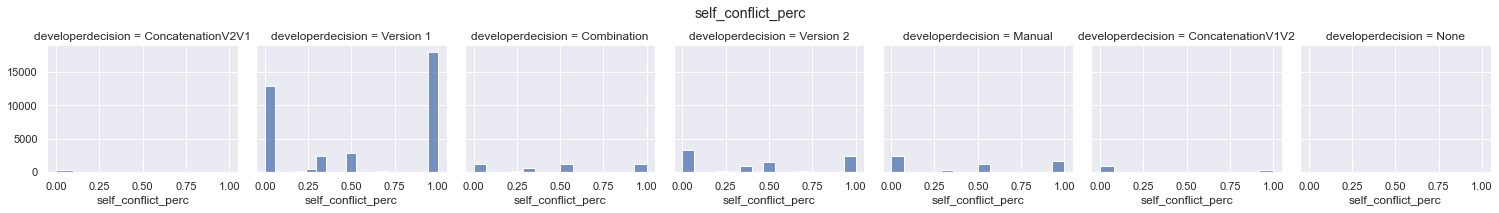

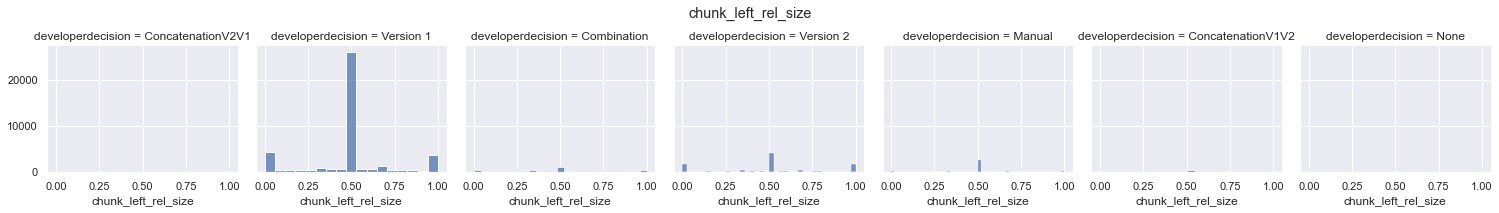

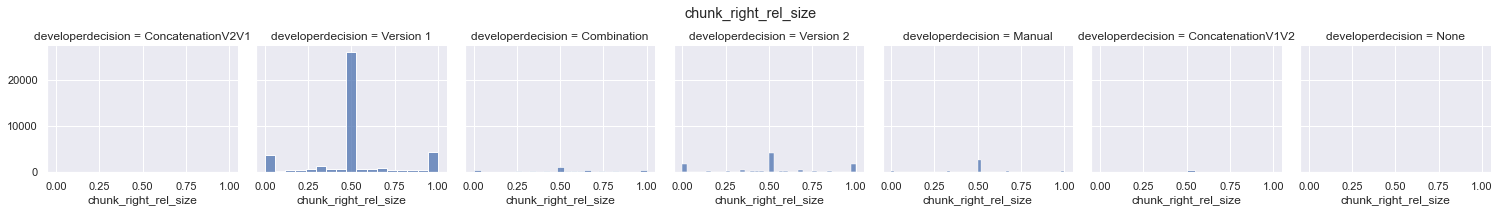

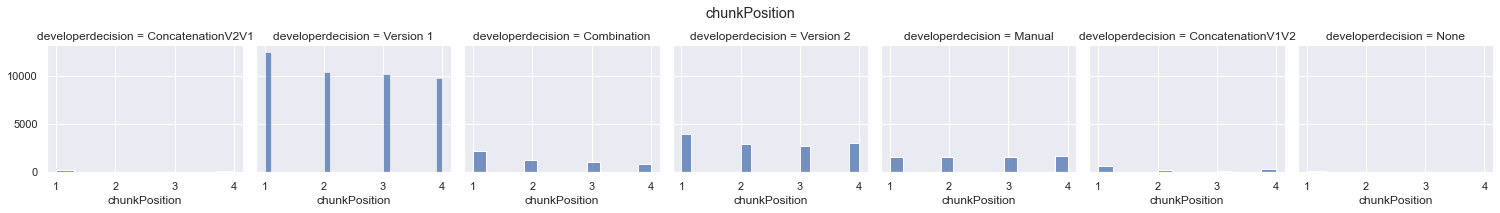

In [10]:
utils_attributes_analysis.hist_plot_by_category(chunk_columns_float, df, 'developerdecision')

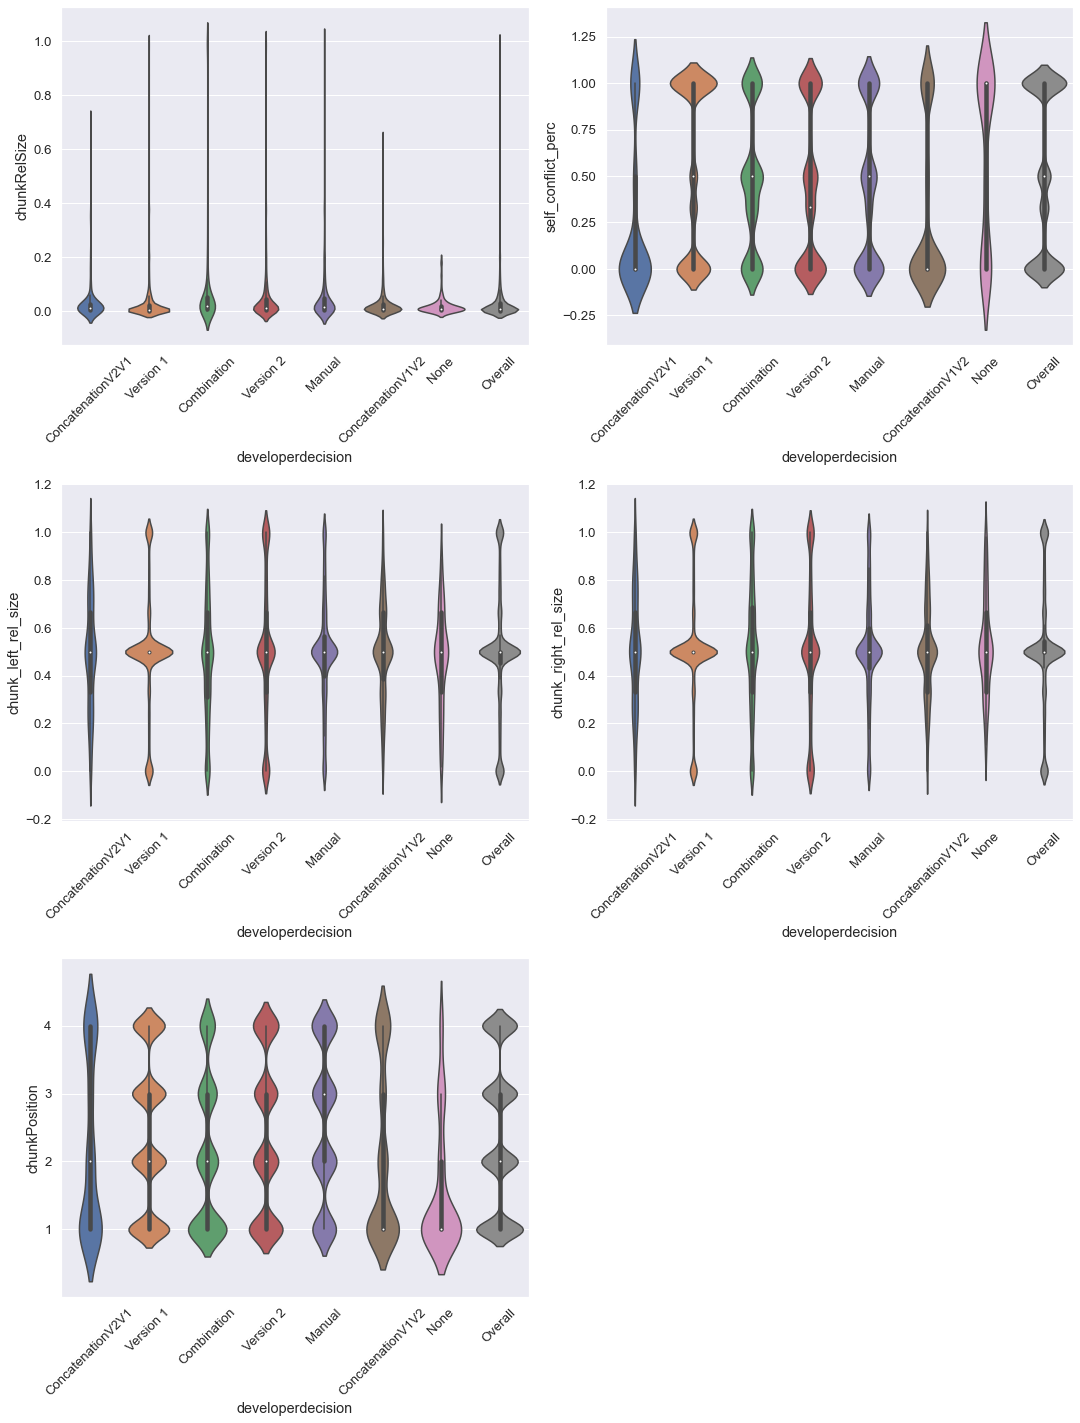

In [11]:
utils_attributes_analysis.violin_by_category(chunk_columns_float, df, 'developerdecision')

### Correlation between chunk continuous attributes and developerdecision <a class="anchor" id="correlation_chunk"></a>

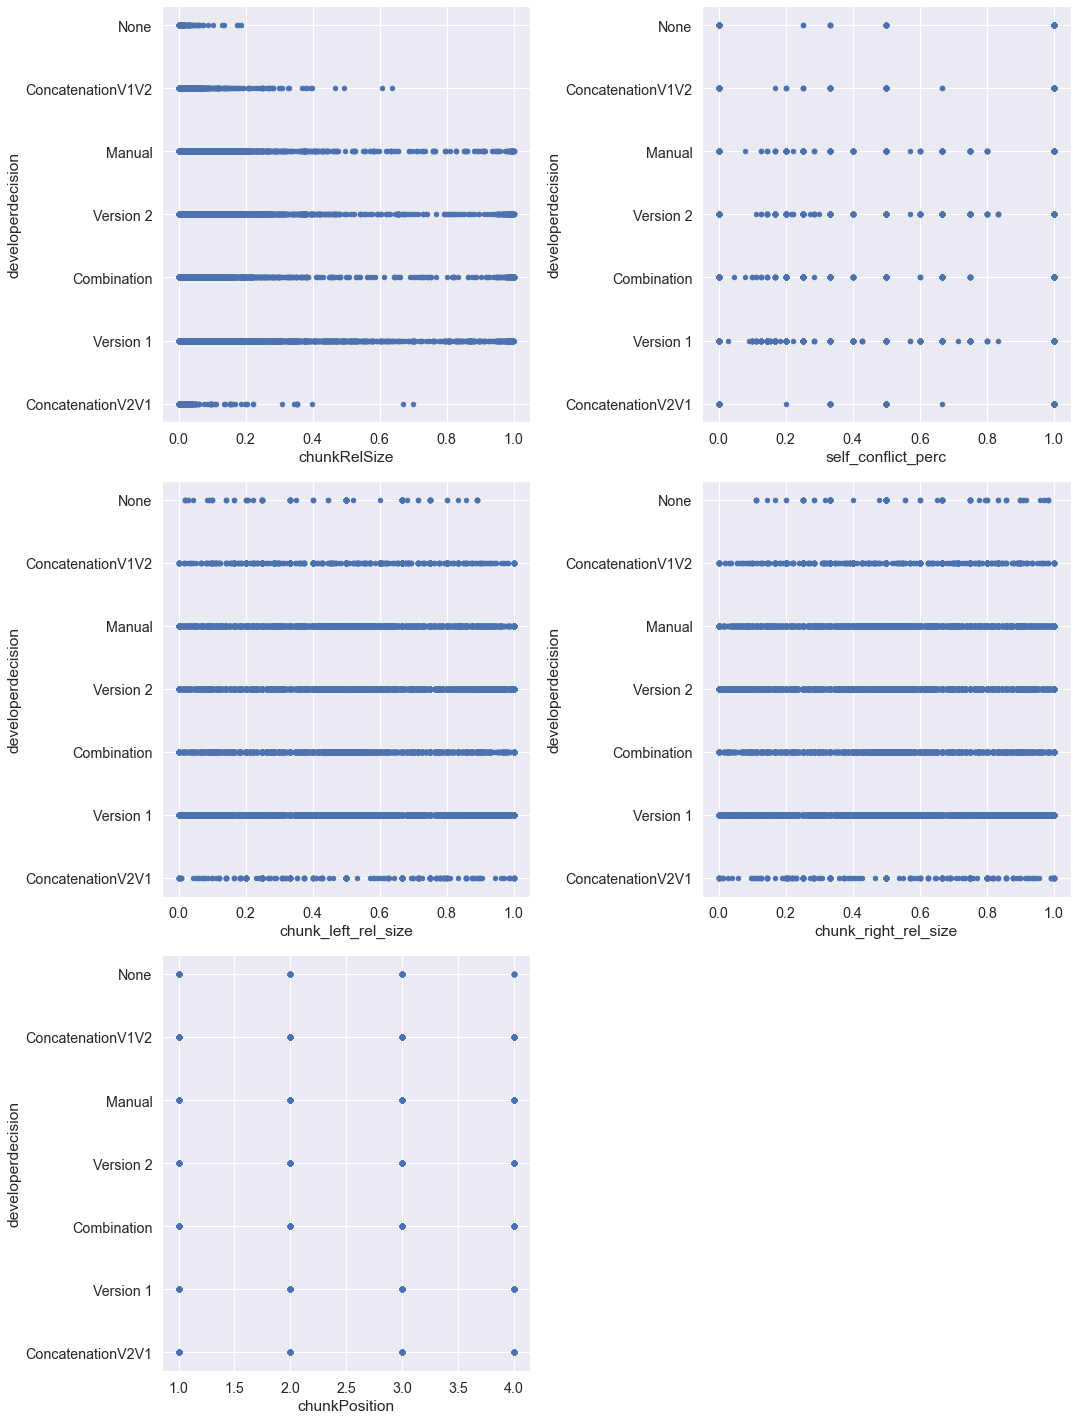

In [12]:
utils_attributes_analysis.scatter_by_category(chunk_columns_float, df, 'developerdecision')

### Probability plots for chunk continuous attributes <a class="anchor" id="chunk_probability"></a>

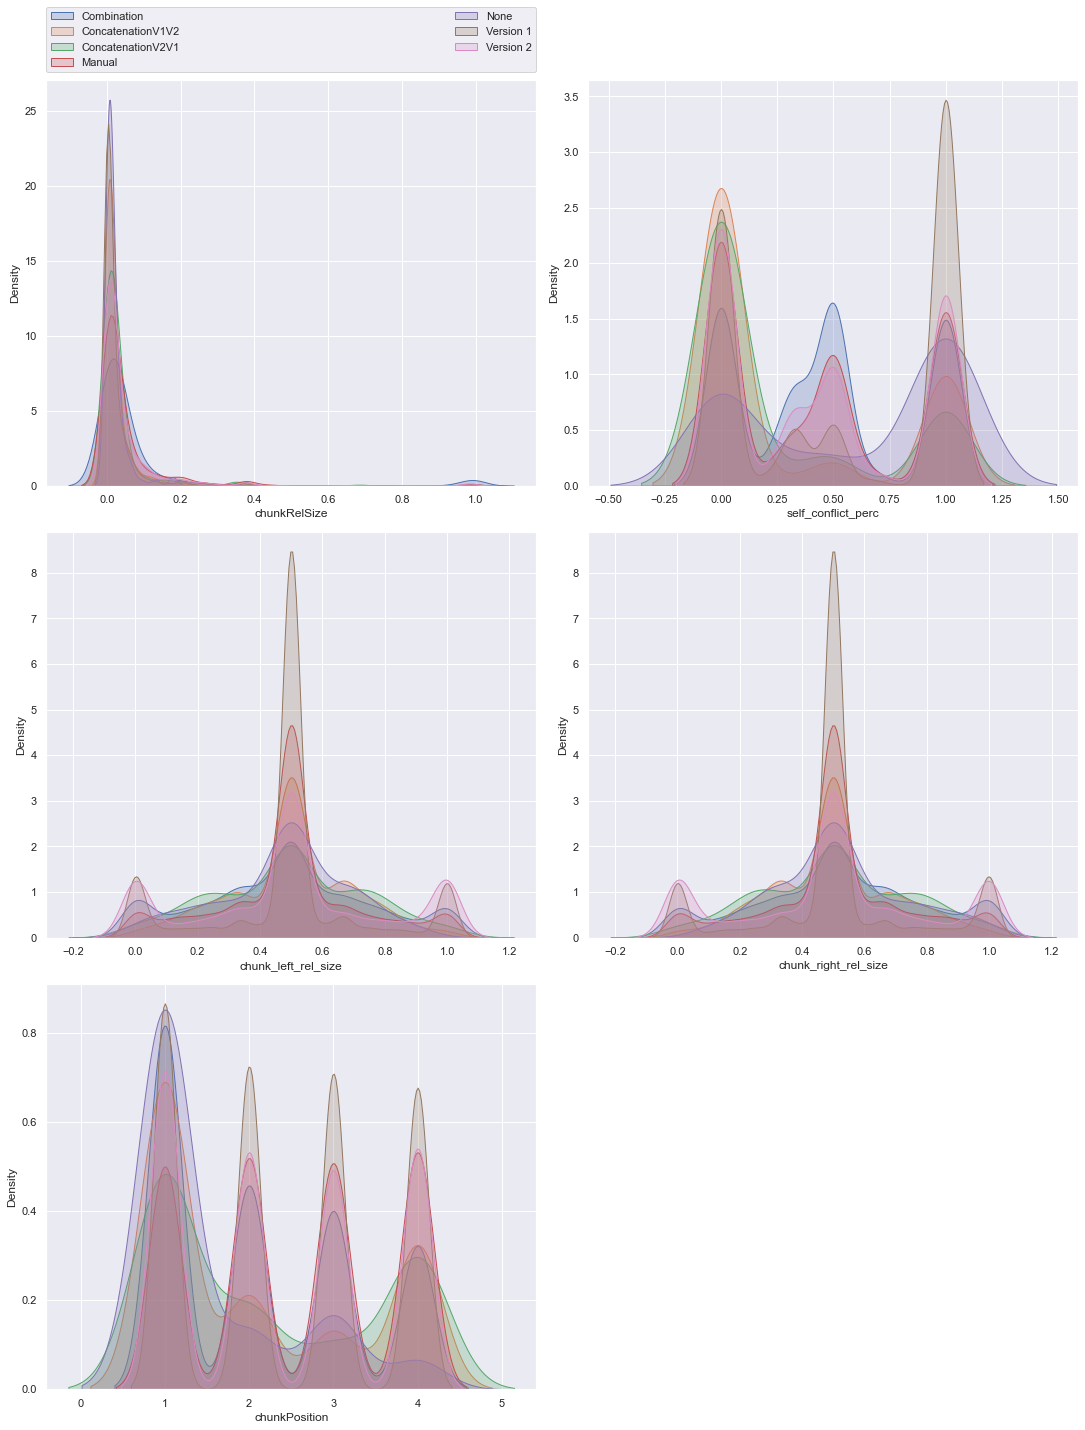

In [13]:
utils_attributes_analysis.density_by_category(chunk_columns_float, df, 'developerdecision', 2)

### Lift analysis for Chunk level attributes <a class="anchor" id="chunk_lift"></a>

In [14]:
all_df_increase = None
all_df_decrease = None
first = True
for file_level_attribute in chunk_columns_categorical:
#     print(f'Lift analysis for {file_level_attribute} attribute:')
    lift, df_confidence, support, df_count = utils.lift_analysis(discretized, file_level_attribute, 'developerdecision')
#     print('Count:')
#     display(df_count)
#     print('Confidence:')
#     display(df_confidence)
#     print('Lift:')
#     display(lift)
    
    threshold = 0.5
    df_increase, df_decrease = utils.get_rules_of_interest(threshold, lift, file_level_attribute, df_confidence, df_count)
    if first:
        all_df_increase = df_increase
        all_df_decrease = df_decrease
        first = False
    else:
        all_df_increase = pd.concat([all_df_increase, df_increase])
        all_df_decrease = pd.concat([all_df_decrease, df_decrease])    

In [15]:
    print(f"Mined rules with at least {threshold*100:.2f}% increased chance")
    display(all_df_increase.sort_values(by=['Lift'], ascending=False))
    
    print(f"Mined rules with at least {threshold*100:.2f}% decreased chance")
    display(all_df_decrease.sort_values(by=['Lift']))

Mined rules with at least 50.00% increased chance


,Rule,Lift,Confidence,Occurrences
0,chunk_right_abs_size=Tens of thousands => Comb...,13.489908,1.000000,1
0,chunk_left_abs_size=Tens of thousands => Combi...,13.489908,1.000000,1
1,chunk_left_abs_size=Thousands => Combination,6.852017,0.507937,32
0,chunkAbsSize=Tens of thousands => Combination,6.744954,0.500000,1
0,leftCC=Hundreds => Combination,6.149811,0.455882,31
1,chunkAbsSize=Tens of thousands => Manual,4.410374,0.500000,1
2,chunkAbsSize=Zero => Manual,3.528300,0.400000,4
2,chunk_left_abs_size=Hundreds => Combination,3.436109,0.254717,189
3,chunkAbsSize=Thousands => Combination,3.151331,0.233607,57
1,chunk_right_abs_size=Hundreds => Combination,2.772290,0.205508,194


Mined rules with at least 50.00% decreased chance


,Rule,Lift,Confidence,Occurrences
0,leftCC=Zero => ConcatenationV1V2,0.107523,0.001949,12
0,chunk_left_abs_size=Zero => ConcatenationV1V2,0.107523,0.001949,12
0,rightCC=Zero => ConcatenationV1V2,0.140307,0.002544,15
0,chunk_right_abs_size=Zero => ConcatenationV1V2,0.140307,0.002544,15
1,leftCC=Hundreds => Version 1,0.221472,0.132353,9
1,chunk_left_abs_size=Hundreds => ConcatenationV1V2,0.223016,0.004043,3
1,chunk_right_abs_size=Thousands => Version 2,0.238277,0.044776,9
2,leftCC=Zero => ConcatenationV2V1,0.250087,0.001624,10
2,chunk_left_abs_size=Zero => ConcatenationV2V1,0.250087,0.001624,10
2,chunk_right_abs_size=Zero => ConcatenationV2V1,0.261071,0.001696,10


## File attributes <a class="anchor" id="file"></a>

### Distribution of file categorical attributes <a class="anchor" id="file_categorical_distribution"></a>

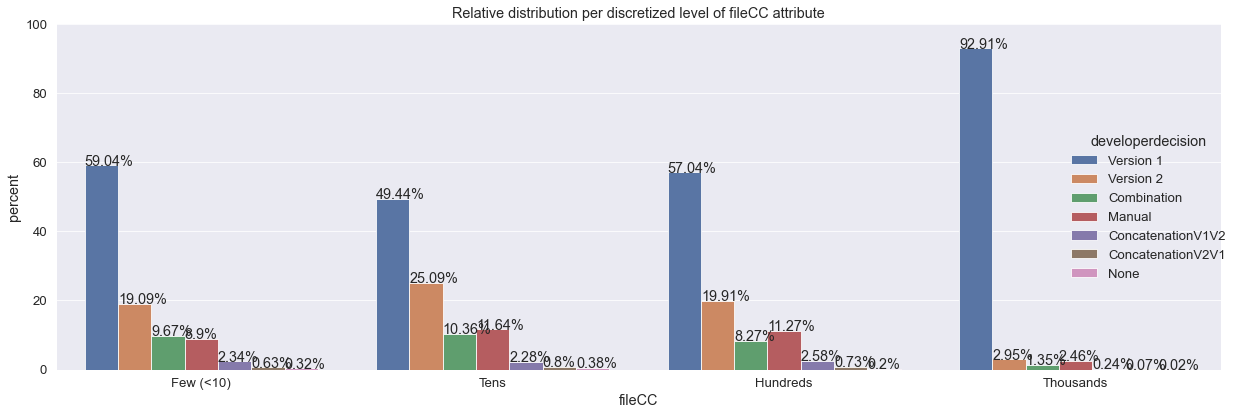

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


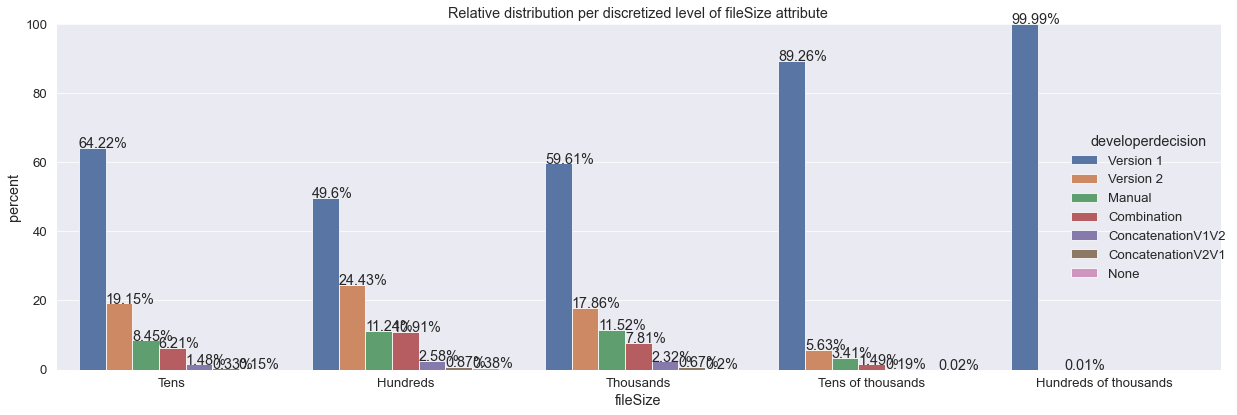

In [16]:
sns.set_context("paper", font_scale=1.5)



for categorical_feature in file_columns_categorical:
    x,y = categorical_feature, 'developerdecision'

    df1 = discretized.groupby(x, observed=True)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, height=6, aspect = 15/6)
    g.ax.set_ylim(0,100)
    g.ax.set_title(f"Relative distribution per discretized level of {categorical_feature} attribute")

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

    plt.tight_layout()
    plt.show()


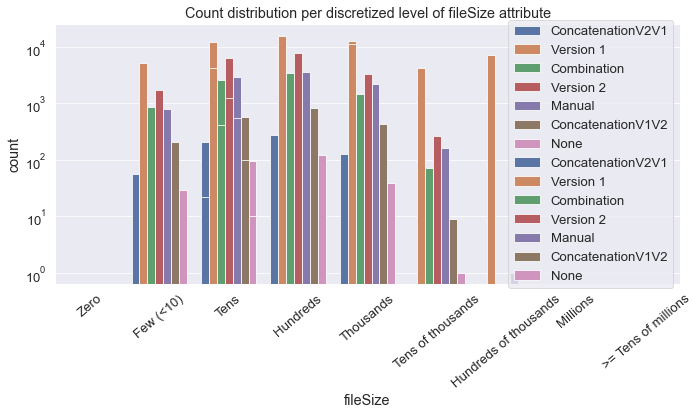

In [17]:
sns.set(font_scale=1)
sns.set_context("paper", font_scale=1.5)

plt.figure(figsize=(10,6))
for categorical_feature in file_columns_categorical:
    g = sns.countplot(x=categorical_feature, hue='developerdecision', data=discretized)
    g.set_yscale("log")
    g.set_title(f"Count distribution per discretized level of {categorical_feature} attribute")
    g.set_xticklabels(labels, rotation=40)

plt.legend(loc='right')
plt.tight_layout()
plt.show()


### Lift analysis for File level attributes <a class="anchor" id="file_lift"></a>

In [18]:
all_df_increase = None
all_df_decrease = None
first = True
for file_level_attribute in file_columns_categorical:
#     print(f'Lift analysis for {file_level_attribute} attribute:')
    lift, df_confidence, support, df_count = utils.lift_analysis(discretized, file_level_attribute, 'developerdecision')
#     print('Count:')
#     display(df_count)
#     print('Confidence:')
#     display(df_confidence)
#     print('Lift:')
#     display(lift)
    
    threshold = 0.5
    df_increase, df_decrease = utils.get_rules_of_interest(threshold, lift, file_level_attribute, df_confidence, df_count)
    if first:
        all_df_increase = df_increase
        all_df_decrease = df_decrease
        first = False
    else:
        all_df_increase = pd.concat([all_df_increase, df_increase])
        all_df_decrease = pd.concat([all_df_decrease, df_decrease])  

In [19]:
    print(f"Mined rules with at least {threshold*100:.2f}% increased chance")
    display(all_df_increase.sort_values(by=['Lift'], ascending=False))
    
    print(f"Mined rules with at least {threshold*100:.2f}% decreased chance")
    display(all_df_decrease.sort_values(by=['Lift']))

Mined rules with at least 50.00% increased chance


,Rule,Lift,Confidence,Occurrences
0,fileSize=Hundreds of thousands => Version 1,1.673116,0.999864,7371
0,fileCC=Tens => None,1.594785,0.003755,95
1,fileSize=Hundreds => None,1.594068,0.003753,120
1,fileCC=Thousands => Version 1,1.554732,0.929117,13016


Mined rules with at least 50.00% decreased chance


,Rule,Lift,Confidence,Occurrences
0,fileSize=Hundreds of thousands => Manual,0.001197,0.000136,1
1,fileSize=Tens of thousands => None,0.089298,0.000210,1
0,fileCC=Thousands => None,0.090949,0.000214,3
2,fileSize=Tens of thousands => ConcatenationV1V2,0.104381,0.001892,9
1,fileCC=Thousands => ConcatenationV2V1,0.109896,0.000714,10
2,fileCC=Thousands => ConcatenationV1V2,0.129935,0.002356,33
3,fileCC=Thousands => Version 2,0.156884,0.029481,413
4,fileCC=Thousands => Combination,0.181997,0.013491,189
3,fileSize=Tens of thousands => Combination,0.201384,0.014929,71
5,fileCC=Thousands => Manual,0.217229,0.024627,345


## Merge attributes <a class="anchor" id="merge"></a>

### Distribution of merge categorical attributes <a class="anchor" id="merge_categorical_distribution"></a>

In [20]:
merge_columns_categorical_1 = merge_columns_categorical[:len(merge_columns_categorical)//2]
merge_columns_categorical_2 = merge_columns_categorical[len(merge_columns_categorical)//2:]

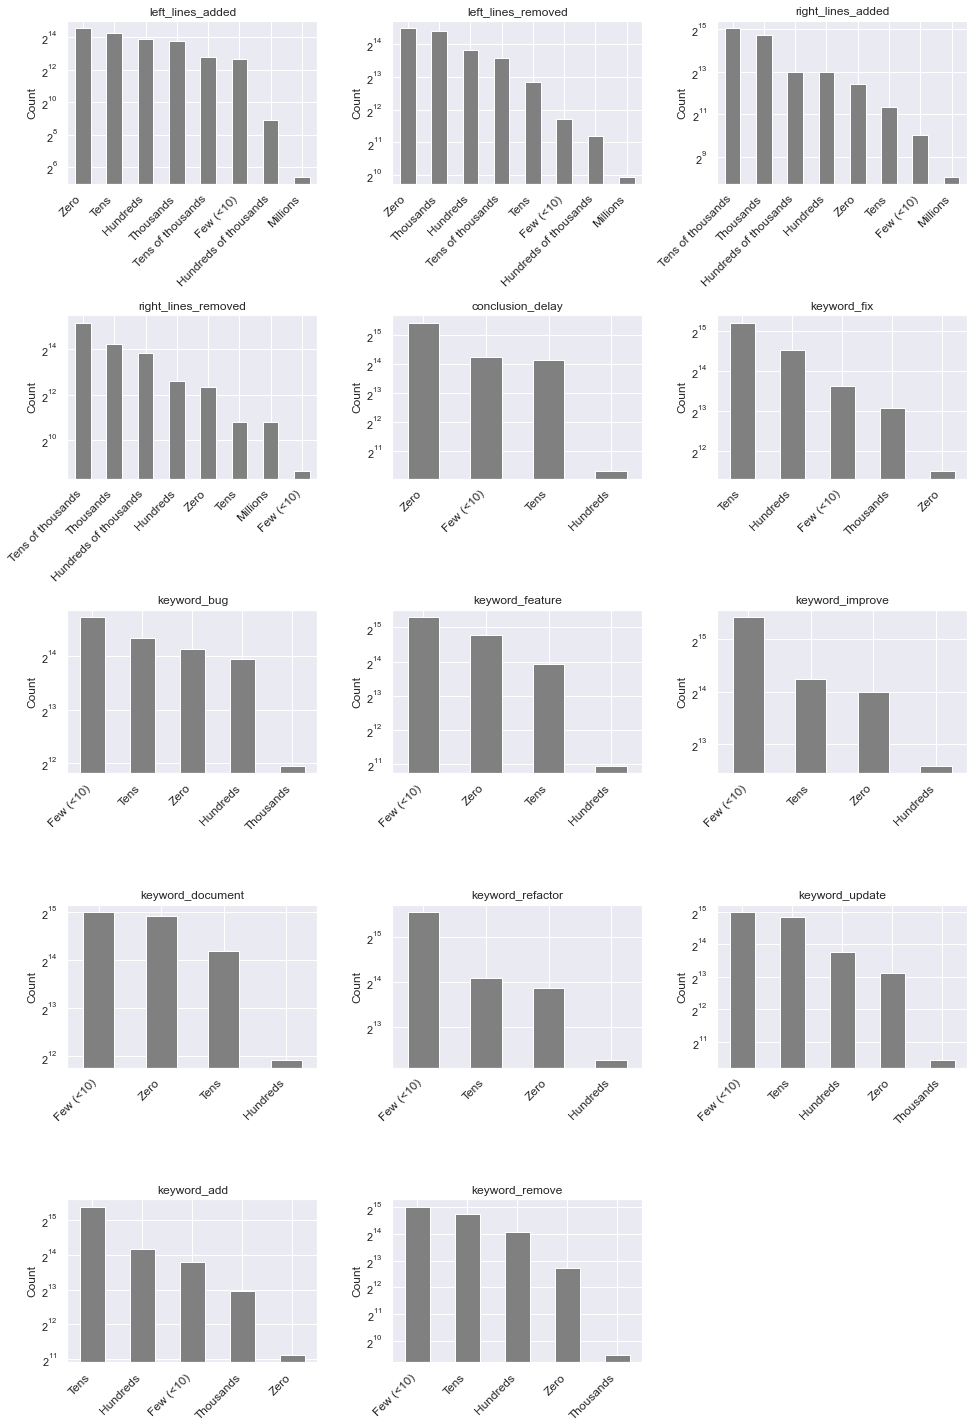

In [21]:
utils_attributes_analysis.count_plot_categorical(merge_columns_categorical_1, discretized, 3, True, 2)

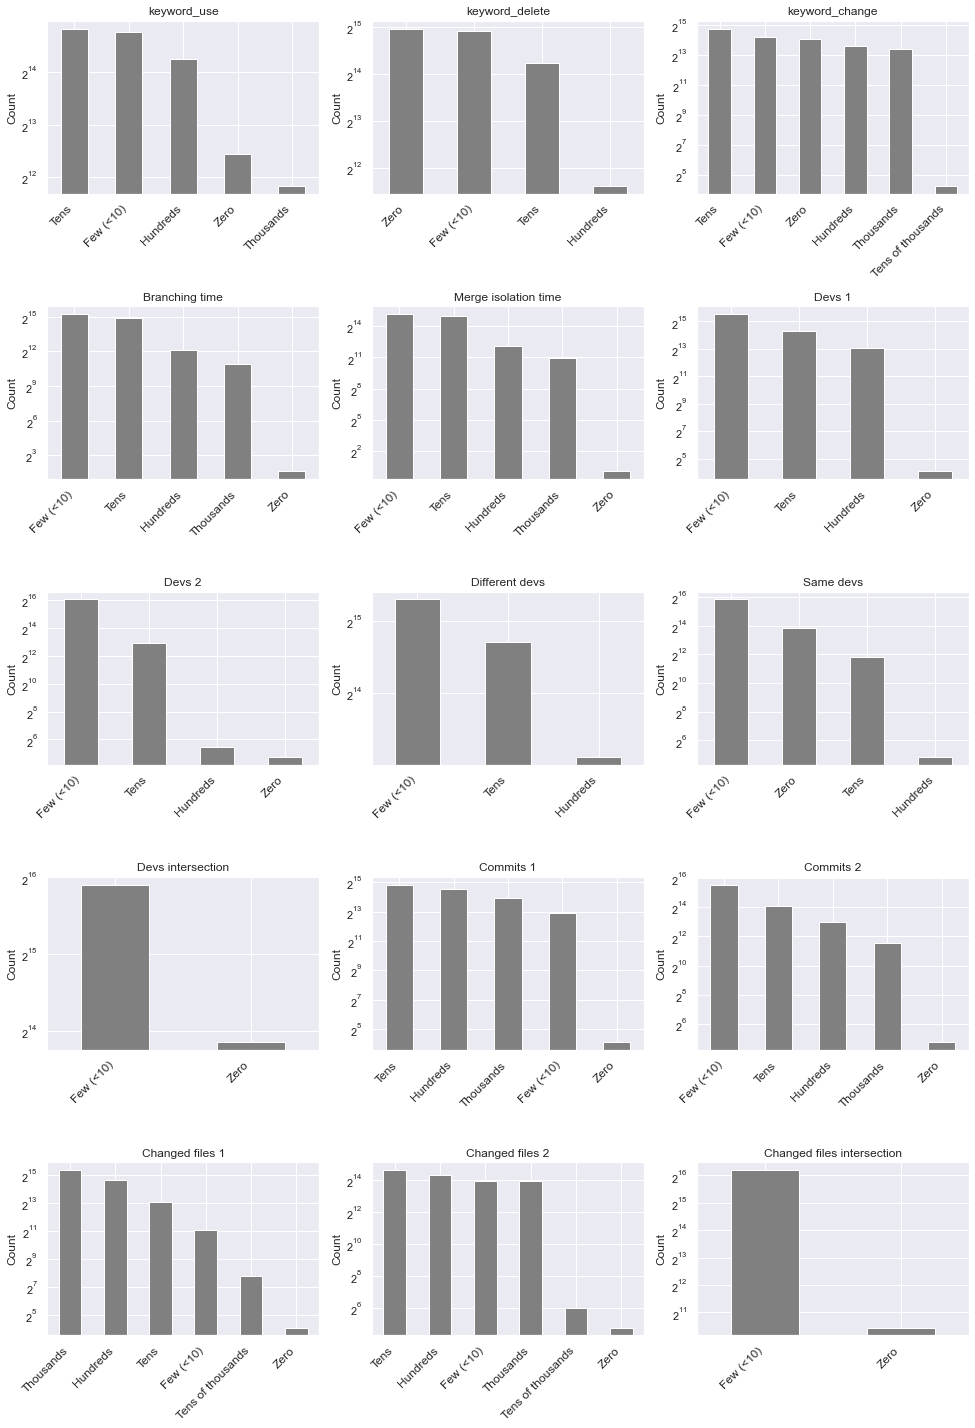

In [22]:
utils_attributes_analysis.count_plot_categorical(merge_columns_categorical_2, discretized, 3, True, 2)

### Lift analysis for Merge level attributes <a class="anchor" id="merge_lift"></a>

In [23]:
all_df_increase = None
all_df_decrease = None
first = True
for file_level_attribute in merge_columns_categorical:
#     print(f'Lift analysis for {file_level_attribute} attribute:')
    lift, df_confidence, support, df_count = utils.lift_analysis(discretized, file_level_attribute, 'developerdecision')
#     print('Count:')
#     display(df_count)
#     print('Confidence:')
#     display(df_confidence)
#     print('Lift:')
#     display(lift)
    
    threshold = 0.5
    df_increase, df_decrease = utils.get_rules_of_interest(threshold, lift, file_level_attribute, df_confidence, df_count)
    if first:
        all_df_increase = df_increase
        all_df_decrease = df_decrease
        first = False
    else:
        all_df_increase = pd.concat([all_df_increase, df_increase])
        all_df_decrease = pd.concat([all_df_decrease, df_decrease])    

In [24]:
    print(f"Mined rules with at least {threshold*100:.2f}% increased chance")
    display(all_df_increase[all_df_increase['Occurrences'] > 3].sort_values(by=['Lift'], ascending=False))
    
    print(f"Mined rules with at least {threshold*100:.2f}% decreased chance")
    display(all_df_decrease[all_df_decrease['Occurrences'] > 3].sort_values(by=['Lift']))

Mined rules with at least 50.00% increased chance


,Rule,Lift,Confidence,Occurrences
0,Devs 2=Hundreds => ConcatenationV1V2,6.268103,0.113636,5
0,Changed files 2=Tens of thousands => Version 2,4.983649,0.936508,59
1,Changed files 1=Zero => Manual,4.669808,0.529412,9
1,Commits 1=Zero => Manual,4.669808,0.529412,9
1,Devs 1=Zero => Manual,4.669808,0.529412,9
...,...,...,...,...
3,Same devs=Zero => ConcatenationV2V1,1.520992,0.009880,146
1,keyword_improve=Zero => Version 2,1.520342,0.285697,4664
2,keyword_improve=Tens => ConcatenationV2V1,1.513388,0.009830,191
10,left_lines_removed=Hundreds => ConcatenationV1V2,1.512657,0.027423,402


Mined rules with at least 50.00% decreased chance


,Rule,Lift,Confidence,Occurrences
0,left_lines_added=Zero => None,0.071014,0.000167,4
1,left_lines_removed=Zero => ConcatenationV1V2,0.071648,0.001299,30
2,left_lines_removed=Zero => Combination,0.073010,0.005412,125
0,right_lines_added=Millions => Version 2,0.077971,0.014652,4
1,Changed files 1=Tens of thousands => Version 2,0.096317,0.018100,4
...,...,...,...,...
4,conclusion_delay=Tens => Combination,0.489740,0.036304,655
8,right_lines_removed=Millions => Version 2,0.494883,0.092997,162
2,keyword_bug=Hundreds => Manual,0.496288,0.056264,896
5,left_lines_added=Hundreds of thousands => Vers...,0.497480,0.297297,143
